In [1]:
# O bi sempre executa isso aqui antes de começar:
# dataset = pandas.DataFrame(field1,field2,field3,...,fieldN)
# dataset = dataset.drop_duplicates()

from pandas import read_csv,DataFrame,melt
from scipy import stats
import numpy as np
import seaborn as sns
from matplotlib.pyplot import tight_layout,subplots,show
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,PowerTransformer
from blume import table

In [2]:
############################## exclusivo debug: ####################################################
idxName = ['id']
#catFList = ['f_27']
catFList = ['f_27',"f_07","f_08","f_09","f_10","f_11","f_12"]
#discFList = ["f_07","f_08","f_09","f_10","f_11","f_12","f_13","f_14","f_15","f_16","f_17","f_18","f_29","f_30"]
discFList = ["f_13","f_14","f_15","f_16","f_17","f_18","f_29","f_30"]
tgtFList = ["target"]
fileDir = "D:\\Projetos\\competicoes\\featureOps\\data\\tabular-playground-series-may-2022\\train.csv"
featureDF = read_csv(fileDir)
featureDF.set_index(idxName[0],inplace=True,drop=False)
numFList = list(set(featureDF.columns) - set(tgtFList) - set(discFList) - set(catFList))
numDF = featureDF.sample(n=50000)
dataset = melt(featureDF, id_vars = idxName + catFList, value_vars=numFList+discFList,value_name='numfeatures')
dataset = dataset[dataset['variable']=='f_06']
######################################################################################################

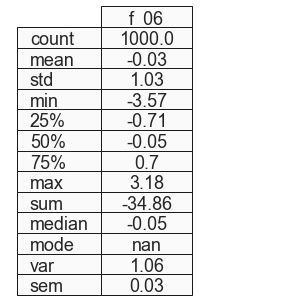

In [3]:
############# LOCAL FLOW : ############################################################
graph_type = 'table'
transform_flag = False
#######################################################################################

############## GLOBAL #################################################################
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
samplesize = read_csv("D:\\Projetos\\competicoes\\featureOps\\data\\dashboards\\biExports\\samplesize.csv")
samplesize = list(samplesize['samplesize'])[0]

if samplesize > len(dataset):
    samplesize = len(dataset)-1

if graph_type != 'table':
    dataset = dataset.sample(n=int(samplesize))

featList = list(dataset['variable'].drop_duplicates())[0]
dataset = dataset[['numfeatures']]
#######################################################################################


def graph_transf():

    global dataset

    transformers = read_csv("D:\\Projetos\\competicoes\\featureOps\\data\\dashboards\\biExports\\transformers.csv")
    transformers = list(transformers['transformers'])[0]
    transDic = {'StandardScaler':StandardScaler(),'MaxAbsScaler':MaxAbsScaler(),'PowerTransformer':PowerTransformer()}
    scaler = transDic[transformers]
    scaler.fit(dataset)
    dataset = DataFrame(scaler.transform(dataset),columns={'numfeatures'})
    
    return None

def graph_hist():

    global dataset

    binsLen = int(round(len(dataset) ** (1/2),0))
    graph = sns.histplot(data=dataset, x="numfeatures",bins=binsLen,kde=True)
    graph.set(title=f'{featList} Frequency Distribuiton')
    graph.set_xlabel("Bins")
    graph.set_ylabel("Frequency")
    #plt.tight_layout()
    show()

def graph_table():

    global dataset
    #nao funciona para 2 features selecionadas ao mesmo tempo
    statsx = dataset.describe().T

    dataset = dataset[['numfeatures']]
    dataset.rename(columns={'numfeatures':featList},inplace=True)

    ###extras:
    statsx['sum'] = dataset[featList].sum()
    statsx['median'] = dataset[featList].median()
    mode = dataset[featList].mode().values
    statsx['mode'] = np.nan if len(mode) > 1 else mode[0]
    statsx['var'] = dataset[featList].var()
    statsx['sem'] = dataset[featList].sem()
    statsx = statsx.T
    statsx[featList] = round(statsx['numfeatures'],2)
    statsx.drop(columns=['numfeatures'],inplace=True)

    fig, ax = subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.figure.set_size_inches(4, 4)

    #cores:
    colors_cell = [['#FAFAFA']]*13
    colors_rows = ['#FAFAFA']*13
    colors_cols = ['#FAFAFA']

    #inferno:
    tablex = table.table(ax,cellText=statsx.values, colLabels=statsx.columns,rowLabels=statsx.index,cellLoc='center',loc='center',colWidths = [0.25],cellColours=colors_cell,rowColours=colors_rows,colColours=colors_cols)
    tablex.auto_set_font_size(False)
    tablex.set_fontsize(18)
    tablex.scale(1.3,1.3) #(COLUMN,ROW)
    tight_layout(pad=0, w_pad=0, h_pad=0)

    show()

def graph_qqplot():

    global dataset
    graph = stats.probplot(dataset['numfeatures'], plot=sns.mpl.pyplot)
    show()

def graph_boxplot():

    global dataset
    graph = sns.boxplot(data=dataset,orient='vertical')
    show()


############## GLOBAL FLOW : ##########################################################
possibleGraphs = {'histogram':graph_hist,'qqplot':graph_qqplot,'boxplot':graph_boxplot,'table':graph_table}
#######################################################################################

graph_transf() if transform_flag else None
possibleGraphs[graph_type]()